<a href="https://colab.research.google.com/github/ankitbhutani1090/value_of_data/blob/main/notebooks/SMM4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import os
import math
import seaborn as sns

project_dir = '/content/drive/MyDrive/Data_GDP_OV'

In [ ]:
rho = 0.953
beta = 0.96                         # discount factor
def val_data_calcs(df, V_med, omega_grid, rev_med=720):
    df['tau_t'] = 0.0
    df['Omega_t'] = 0.0
    df['FV_t'] = 0.0
    df['SV_t'] = 0.0
    df['FV_precision_gain'] = 0.0
    df['SV_precision_gain'] = 0.0
    df['zeta_t'] = 0.0
    df['undep_data'] = 0.0
    df['val_dep'] = 0.0
    df['no_dep_Omega_t'] = 0.0
    df['disc_ratio'] = 0.0

    print(rev_med)
    def nearest_idx(grid, value):
        return np.abs(grid - value).argmin()

    # Period 1
    phi_1 = df.loc[df['fyear'] == 2003, 'phi_t'].values[0]
    fe0 = 1/phi_1
    Omega0 = phi_1
    fe1 = df.loc[df['fyear'] == 2003, 'sq_rel_err'].values[0]
    rev1 = df.loc[df['fyear'] == 2003, 'real_sale'].values[0]
    Omega1 = 1/fe1
    tau1 = Omega1 - Omega0

    FV_data_term = 1/Omega1 - 1/(Omega1 - tau1)
    SV_data_term = 1/Omega1 - 1/phi_1

    # Get nearest indices for prior and posterior
    idx_prior = nearest_idx(omega_grid, 1/phi_1)
    idx_post1  = nearest_idx(omega_grid, 1/(Omega1 - tau1))
    idx_post2  = nearest_idx(omega_grid, 1/Omega1)

    # Compute value differences
    FV1 = (V_med[idx_post2] - V_med[idx_post1]) * rev1/rev_med
    SV1 = (V_med[idx_post2] - V_med[idx_prior]) * rev1/rev_med

    #FV1 = V_med(1/Omega1) - V_med(1/(Omega1 - tau1))
    #SV1 = V_med(1/Omega1) - V_med(1/phi_1)

    df.loc[df['fyear'] == 2003, 'tau_t'] = tau1
    df.loc[df['fyear'] == 2003, 'Omega_t'] = Omega1
    df.loc[df['fyear'] == 2003, 'FV_t'] = FV1
    df.loc[df['fyear'] == 2003, 'SV_t'] = SV1
    df.loc[df['fyear'] == 2003, 'FV_precision_gain'] = -FV_data_term
    df.loc[df['fyear'] == 2003, 'SV_precision_gain'] = -SV_data_term
    zeta_t = 1 - 1/(rho**2 + Omega1/phi_1)
    disc_ratio = 1/(1 + rev1/FV1)
    df.loc[df['fyear'] == 2003, 'disc_ratio'] = disc_ratio

    df.loc[df['fyear'] == 2003, 'zeta_t'] = zeta_t
    df.loc[df['fyear'] == 2003, 'undep_data'] = 0.0
    df.loc[df['fyear'] == 2003, 'no_dep_Omega_t'] = Omega1

    phi_tm1 = phi_1
    fe_tm1 = fe1
    Omega_tm1 = Omega1
    zeta_tm1 = zeta_t

    # Period t
    for t in range(2004, 2023):

        phi_t = df.loc[df['fyear'] == t, 'phi_t'].values[0]
        fe_t = df.loc[df['fyear'] == t, 'sq_rel_err'].values[0]
        rev_t = df.loc[df['fyear'] == t, 'real_sale'].values[0]

        Delta_fe = fe_t - fe_tm1
        Omega_t = 1/(Delta_fe + 1/Omega_tm1)

        undep_data = (1 - zeta_tm1) * (Omega_tm1 - phi_tm1)
        tau_t = Omega_t - phi_t - undep_data

        FV_data_term = (1/Omega_t - 1/(Omega_t - tau_t))
        SV_data_term = (1/Omega_t - 1/phi_t)

        # Get nearest indices for prior and posterior
        idx_prior = nearest_idx(omega_grid, 1/phi_t)
        idx_post1  = nearest_idx(omega_grid, 1/(Omega_t - tau_t))
        idx_post2  = nearest_idx(omega_grid, 1/Omega_t)


        # Compute value differences
        FV_t = (V_med[idx_post2] - V_med[idx_post1]) * rev_t/rev_med
        SV_t = (V_med[idx_post2] - V_med[idx_prior]) * rev_t/rev_med

        no_dep_Omega_t = phi_t + Omega_tm1 - phi_tm1 + tau_t

        idx_ndO = nearest_idx(omega_grid, no_dep_Omega_t)
        val_dep = V_med[idx_ndO] - V_med[idx_post2]

        df.loc[df['fyear'] == t, 'tau_t'] = tau_t
        df.loc[df['fyear'] == t, 'Omega_t'] = Omega_t
        df.loc[df['fyear'] == t, 'FV_t'] = FV_t
        df.loc[df['fyear'] == t, 'SV_t'] = SV_t
        df.loc[df['fyear'] == t, 'FV_precision_gain'] = -FV_data_term
        df.loc[df['fyear'] == t, 'SV_precision_gain'] = -SV_data_term
        df.loc[df['fyear'] == t, 'undep_data'] = undep_data
        df.loc[df['fyear'] == t, 'no_dep_Omega_t'] = no_dep_Omega_t
        df.loc[df['fyear'] == t, 'val_dep'] = val_dep

        zeta_t = 1 - 1/(rho**2 + Omega_t/phi_t)
        disc_ratio = 1/(1 + rev_t/FV_t)

        df.loc[df['fyear'] == t, 'zeta_t'] = zeta_t
        df.loc[df['fyear'] == t, 'disc_ratio'] = disc_ratio

        phi_tm1 = phi_t
        fe_tm1 = fe_t
        Omega_tm1 = Omega_t
        zeta_tm1 = zeta_t

    return df


def plot_single_var(df, var1, lab1, ylab, title, filename):
    # Ensure fyear is sorted and unique
    years = sorted(df['fyear'].unique())
    alternate_years = years[::2]  # Take every second year

    # Set up the plot
    plt.figure(figsize=(10, 6))

    # Plot both variables
    plt.plot(df['fyear'], df[var1], label=lab1, marker='o')

    # Add labels and title
    plt.xlabel('Financial Year')
    plt.ylabel(ylab)
    plt.title(title)

    # Set alternate x-ticks
    plt.xticks(alternate_years)

    # Add legend and grid
    plt.legend()
    plt.tight_layout()

    # Save the figure
    plt.savefig(f'{project_dir}/Output/Figures/{filename}', dpi=300)

    # Show the plot
    plt.show()

def plot_output(df, var_list, lab_list, ylab, title, filename):
    # Ensure fyear is sorted and unique
    years = sorted(df['fyear'].unique())
    alternate_years = years[::2]  # Take every second year

    # Define a list of markers to cycle through
    markers = ['o', '|', 'x']

    # Set up the plot
    plt.figure(figsize=(10, 6))

    # Iterate over var_list, lab_list, and markers to make the plots
    for i, (var, lab) in enumerate(zip(var_list, lab_list)):
        # Use the modulo operator to cycle through markers
        marker = markers[i % len(markers)]
        plt.plot(df['fyear'], df[var], label=lab, marker=marker)

    plt.axhline(0, color='grey', linewidth=0.8)

    # Add labels and title
    plt.xlabel('Financial Year', fontsize=18) # Increased font size
    plt.ylabel(ylab, fontsize=18) # Increased font size
    plt.title(title, fontsize=18) # Increased font size

    # Set alternate x-ticks and increase font size
    plt.xticks(alternate_years, fontsize=18)
    plt.yticks(fontsize=18) # Increased font size

    # Add legend and grid, and increase legend font size
    plt.legend(fontsize=18)
    plt.tight_layout()

    # Save the figure
    plt.savefig(f'{project_dir}/Output/Figures/{filename}', dpi=300)

    # Show the plot
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
from scipy.special import erfinv  # for lognormal quantile grid
import statsmodels.api as sm

# =================================
# Global constants / numeric floors
# =================================
BETA       = 1.0 / 1.04  # discount factor (r ~ 0.04)
PROD_FLOOR = 0.1         # min productivity term (flow & realized)
DEN_FLOOR  = 2.0         # min denominator in omega mapping
RATIO_EPS  = 1e-12       # floor inside log(Rev/Rev_M)
VFI_TOL    = 1e-6        # convergence tolerance for VFI
VFI_MAXIT  = 500         # max VFI iterations


from dataclasses import dataclass

@dataclass
class DiagLite:
    # --- VFI (solve) ---
    flow_floor_hits: int = 0          # # times A - γ·ω (or (1-γ·ω)A) was floored at PROD_FLOOR
    flow_total_vfi: int = 0           # total # flow checks (≈ Nw per VFI iteration per a-node)
    den_floor_hits_vfi: int = 0       # # times omega denominator floored at DEN_FLOOR
    den_total_vfi: int = 0            # total # denominator evaluations in VFI (≈ Nw*Nk per iter per a-node)
    k_at_min_states: int = 0          # # states where policy picked k_min
    k_at_max_states: int = 0          # # states where policy picked k_max
    states_count: int = 0             # total # states considered for policy edges (≈ Nw per VFI iteration per a-node)
    nans_vfi: int = 0                 # # NaN/Inf incidents in VFI

    # --- Simulation ---
    real_floor_hits: int = 0          # # times A - γ·ψ² (or (1-γ·ψ²)A) was floored at PROD_FLOOR
    real_total_sim: int = 0           # total firm-years
    den_floor_hits_sim: int = 0       # # times omega denominator floored at DEN_FLOOR
    den_total_sim: int = 0            # total # denom evaluations in SIM (== firm-years)
    omega_at_min_sim: int = 0         # # times ω' hit lower grid bound
    omega_at_max_sim: int = 0         # # times ω' hit upper grid bound
    omega_updates_sim: int = 0        # total # ω updates (== firm-years)
    nans_sim: int = 0                 # # NaN/Inf incidents in SIM

    def report(self, label=""):
        msgs = []

        # VFI percentages
        if self.flow_total_vfi > 0 and self.flow_floor_hits > 0:
            pct = 100.0 * self.flow_floor_hits / self.flow_total_vfi
            msgs.append(f"[{label}] flow productivity floored: {pct:.2f}% "
                        f"({self.flow_floor_hits}/{self.flow_total_vfi})")
        if self.den_total_vfi > 0 and self.den_floor_hits_vfi > 0:
            pct = 100.0 * self.den_floor_hits_vfi / self.den_total_vfi
            msgs.append(f"[{label}] omega-denominator floored (VFI): {pct:.2f}% "
                        f"({self.den_floor_hits_vfi}/{self.den_total_vfi})")
        if self.states_count > 0:
            pct_min = 100.0 * self.k_at_min_states / self.states_count
            pct_max = 100.0 * self.k_at_max_states / self.states_count
            msgs.append(f"[{label}] policy grid hits: k_min={pct_min:.2f}%, "
                        f"k_max={pct_max:.2f}% (of {self.states_count} states)")
        if self.nans_vfi:
            msgs.append(f"[{label}] NaNs/Infs in VFI: {self.nans_vfi}")

        # SIM percentages
        if self.real_total_sim > 0 and self.real_floor_hits > 0:
            pct = 100.0 * self.real_floor_hits / self.real_total_sim
            msgs.append(f"[{label}] realized productivity floored: {pct:.2f}% "
                        f"({self.real_floor_hits}/{self.real_total_sim})")
        if self.den_total_sim > 0 and self.den_floor_hits_sim > 0:
            pct = 100.0 * self.den_floor_hits_sim / self.den_total_sim
            msgs.append(f"[{label}] omega-denominator floored (SIM): {pct:.2f}% "
                        f"({self.den_floor_hits_sim}/{self.den_total_sim})")
        if self.omega_updates_sim > 0 and (self.omega_at_min_sim or self.omega_at_max_sim):
            pct_min = 100.0 * self.omega_at_min_sim / self.omega_updates_sim
            pct_max = 100.0 * self.omega_at_max_sim / self.omega_updates_sim
            msgs.append(f"[{label}] omega bound hits (SIM): min={pct_min:.2f}%, "
                        f"max={pct_max:.2f}% (of {self.omega_updates_sim} updates)")
        if self.nans_sim:
            msgs.append(f"[{label}] NaNs/Infs in SIM: {self.nans_sim}")

        if msgs:
            print("\n".join(msgs))


# ==========================
# Utilities
# ==========================
def lognormal_grid(mu_lnA, sd_lnA, N):
    """
    Quantile grid for A from LogNormal(mu, sd) using inverse-CDF of Normal.
    """
    qs = np.linspace(0.01, 0.99, N)
    lnA = mu_lnA + sd_lnA * np.sqrt(2.0) * erfinv(2 * qs - 1)
    return np.exp(lnA)

def productivity_term(a, varTerm, gamma, mode, w):
    """
    mode: 'additive' or 'multiplicative'
    varTerm: omega (flow) or psi^2 (realized)
    Returns floored productivity coefficient.
    """
    if mode == "additive":
        raw = a - gamma * varTerm - w
        prod = np.maximum(raw, PROD_FLOOR)
    elif mode == "multiplicative":
        raw1 = np.maximum(1.0 - gamma * varTerm, PROD_FLOOR)
        raw2 = a * raw1 - w
        prod = np.maximum(raw2, PROD_FLOOR)
    else:
        raise ValueError("mode must be 'additive' or 'multiplicative'")
    return prod

def omega_next_from_rev(Rev, phi, tau, chi, Rev_M):
    """
    Implements: omega' = 1 / max(phi + tau + chi * log(max(Rev/Rev_M, eps)), DEN_FLOOR).
    Returns (omega_next, den_raw, den_floored)
    """
    ratio = np.maximum(Rev / Rev_M, RATIO_EPS)
    den   = phi + tau + chi * np.log(ratio)
    den_f = np.maximum(den, DEN_FLOOR)
    return 1.0 / den_f, den, den_f


# ==========================
# Grid builder (robust-ish)
# ==========================
def make_grids(mu_lnA, sd_lnA,
               N_a=9, N_w=60, N_k=80,
               alpha=1/3, r=0.04,
               phi=142.86, tau=312.04, chi=3.0, Rev_M=692.357,
               gamma=2.0, prod_mode="additive", w = 0.01,
               k_min=1e-6, logRev_cap=11, a_ref_q=0.99,
               omega_min = 1e-7, omega_max = 0.2):
    """
    Builds (a_grid, omega_grid, k_grid).
      - a_grid: lognormal quantiles
      - k_grid: geometric [k_min, k_max] based on myopic at worst-info omega ≈ 1/phi
      - omega_grid: geometric between model-based bounds implied by log link
    """
    a_grid = lognormal_grid(mu_lnA, sd_lnA, N_a)
    A_ref = np.quantile(a_grid, a_ref_q)

    # k_max from myopic formula at worst-info omega ≈ 1/phi, using selected productivity spec
    omega_worst = 1.0 / 2
    coeff_flow_worst = productivity_term(A_ref, omega_worst, gamma, prod_mode, w)
    base = (alpha / r) * coeff_flow_worst
    k_ref = base ** (1.0 / (1.0 - alpha))

    # conservative cap via data-driven Rev cap
    Rev_cap = float(np.exp(logRev_cap))
    # Use A_ref for rough cap: Rev ≈ A_ref * k^alpha <= Rev_cap
    k_cap = (Rev_cap / max(A_ref, 1e-12)) ** (1.0 / alpha)
    #print(f"kcap = {k_cap}, multiplier = {k_ref_multiplier * k_ref}")
    #k_max = float(min(k_ref_multiplier * k_ref, k_cap))
    k_max = k_cap
    print(f"k_max = {k_max}")
    k_grid = np.geomspace(k_min, k_max, N_k)  # dense near zero

    # omega bounds via log link
    # Best-info reference (use Rev from flow coeff at k_ref)
    Rev_ref = min(Rev_cap, coeff_flow_worst * (k_ref ** alpha))
    #omega_min, den_ref, den_ref_f = omega_next_from_rev(Rev_ref, phi, tau, chi, Rev_M)

    #omega_min = 0.0001 # Override omega_min

    # Worst-info reference (small revenue fraction)
    ratio_worst = 0.05
    Rev_worst   = ratio_worst * Rev_M
    #omega_max, den_worst, den_worst_f = omega_next_from_rev(Rev_worst, phi, tau, chi, Rev_M)

    #omega_max = 0.05 # Override omega_max

    omega_grid = np.geomspace(omega_min, omega_max, N_w)

    print(f"[Grids] A_ref(q={a_ref_q:.2f})={A_ref:.3g} | k_max={k_max:.3g}")
    print(f"[Grids] Rev_ref={Rev_ref:.3g} | omega_min={omega_min:.3e}")
    print(f"[Grids] worst Rev={Rev_worst:.3g} | omega_max={omega_max:.3e}")

    return a_grid, omega_grid, k_grid


# ==========================
# VFI (per a-node), vectorized
# ==========================
def solve_vfi_for_a(a, omega_grid, k_grid, alpha, r, phi, tau, chi, Rev_M,
                    gamma, prod_mode, w, diag: DiagLite):
    """
    Solves V(omega; a) and policy k*(omega; a) on grids via value function iteration.
    Transition uses expected-flow productivity (omega) for Rev in the mapping.
    """
    Nw, Nk = len(omega_grid), len(k_grid)
    V = np.zeros(Nw)
    policy_idx = np.zeros(Nw, dtype=int)

    for it in range(VFI_MAXIT):
        # Flow payoff for all states and k
        coeff_flow = productivity_term(a, omega_grid[:, None], gamma, prod_mode, w)  # (Nw,1)
        flow = coeff_flow * (k_grid[None, :] ** alpha) - r * k_grid[None, :]

        # Count how often flow coeff was floored (diagnostic prints only if >0 overall)
        if prod_mode == "additive":
            raw_flow = a - gamma * omega_grid[:, None] - w
        else:
            raw_flow = (1.0 - gamma * omega_grid[:, None]) * a - w
        diag.flow_floor_hits += int(np.count_nonzero(raw_flow < PROD_FLOOR))
        diag.flow_total_vfi  += raw_flow.size
        diag.states_count += Nw

        # Omega' from Rev using flow coeff (deterministic transition for VFI)
        Rev_flow = coeff_flow * (k_grid[None, :] ** alpha)  # (Nw,Nk)
        ratio = np.maximum(Rev_flow / Rev_M, RATIO_EPS)
        den_raw = phi + tau + chi * np.log(ratio)           # (Nw,Nk)
        den_f = np.maximum(den_raw, DEN_FLOOR)
        diag.den_floor_hits_vfi += int(np.count_nonzero(den_raw < DEN_FLOOR - 1e-12))
        diag.den_total_vfi      += den_raw.size
        omega_next = 1.0 / den_f

        # Interpolate V at omega_next (linear)
        idx = np.clip(np.searchsorted(omega_grid, omega_next, side='left') - 1, 0, Nw - 2)
        w_hi = omega_grid[idx + 1]
        w_lo = omega_grid[idx]
        weight = np.divide(omega_next - w_lo, w_hi - w_lo, out=np.zeros_like(omega_next), where=(w_hi > w_lo))
        V_next = (1.0 - weight) * V[idx] + weight * V[idx + 1]

        RHS = flow + BETA * V_next
        new_idx = np.argmax(RHS, axis=1)
        V_new = RHS[np.arange(Nw), new_idx]

        # policy boundary hits
        diag.k_at_min_states += int(np.count_nonzero(new_idx == 0))
        diag.k_at_max_states += int(np.count_nonzero(new_idx == Nk - 1))

        # NaN/Inf guard
        if not np.isfinite(V_new).all():
            diag.nans_vfi += 1
            V_new = np.where(np.isfinite(V_new), V_new, V)

        diff = np.max(np.abs(V_new - V))
        V = V_new
        policy_idx = new_idx

        if diff < VFI_TOL:
            break

    return V, policy_idx


def solve_policy(a_grid, omega_grid, k_grid, alpha, r, phi, tau, chi, Rev_M, gamma, prod_mode, w):
    diag = DiagLite()
    policies = []
    values = []
    for a in a_grid:
        V_a, pol_idx_a = solve_vfi_for_a(
            a, omega_grid, k_grid, alpha, r, phi, tau, chi, Rev_M,
            gamma, prod_mode, w, diag
        )
        policies.append(pol_idx_a)
        values.append(V_a)
    policies = np.stack(policies, axis=0)  # (Na, Nw)
    values = np.stack(values, axis=0)      # (Na, Nw)

    # Only print if something actually hit
    diag.report(label="VFI")
    return values, policies, diag


# ==========================
# Simulation -> DataFrame
# ==========================
def simulate_panel(N_firms, T, a_grid, omega_grid, k_grid, policies,
                   mu_lnA, sd_lnA, alpha, phi, tau, chi, Rev_M,
                   gamma, prod_mode, w, seed=2025):
    rng = np.random.default_rng(seed)
    # draw permanent A_i ~ LogNormal
    lnA = rng.normal(mu_lnA, sd_lnA, size=N_firms)
    A = np.exp(lnA)

    # init states (start from median omega)
    omega0 = float(np.median(omega_grid))
    omega = np.full(N_firms, omega0)

    # nearest-neighbor indexers
    def idx_a(a_i):
        return int(np.clip(np.searchsorted(a_grid, a_i, side='left'), 1, len(a_grid)-1) - 1)
    def idx_w(w_i):
        return int(np.clip(np.searchsorted(omega_grid, w_i, side='left'), 1, len(omega_grid)-1) - 1)

    rows = []
    diag = DiagLite()

    for t in range(T):
        for i in range(N_firms):
            a_i = A[i]
            iw  = idx_w(omega[i])
            ia  = idx_a(a_i)
            k   = k_grid[policies[ia, iw]]

            # realized productivity with psi^2
            z   = rng.standard_normal()
            psi2 = omega[i] * (z ** 2)
            coeff_real = productivity_term(a_i, psi2, gamma, prod_mode, w)
            if coeff_real <= PROD_FLOOR + 1e-14:
                diag.real_floor_hits += 1
            diag.real_total_sim += 1

            Rev  = coeff_real * (k ** alpha)
            FE   = psi2

            # omega update with log link (den floored at 2)
            ratio = max(Rev / Rev_M, RATIO_EPS)
            den_raw = phi + tau + chi * np.log(ratio)
            if den_raw < DEN_FLOOR - 1e-12:
                diag.den_floor_hits_sim += 1
            den = max(den_raw, DEN_FLOOR)
            omega_new = 1.0 / den

            # bound hits (relative to grid)
            diag.omega_updates_sim += 1
            if omega_new <= omega_grid[0] * (1 + 1e-12):
                diag.omega_at_min_sim += 1
            if omega_new >= omega_grid[-1] * (1 - 1e-12):
                diag.omega_at_max_sim += 1

            if not (np.isfinite(Rev) and np.isfinite(omega_new)):
                diag.nans_sim += 1

            # record row
            rows.append({
                "firm": i,
                "time": t,
                "Rev":  float(Rev),
                "FE":   float(FE),
                "K":    float(k),
                "Omega":float(omega[i]),
                "A":    float(a_i),
                "lnA":  float(np.log(max(a_i, 1e-300))),
            })

            # advance state
            omega[i] = omega_new

    # Print only if something was hit / useful
    diag.report(label="SIM")

    # Build tidy panel DataFrame
    df = pd.DataFrame(rows).sort_values(["firm","time"]).reset_index(drop=True)
    return df, diag


# ==========================
# Moments & regressions (DataFrame)
# ==========================

def median_k_alpha(a_grid, omega_grid, k_grid, policies, mu_lnA, alpha):
    A_med = np.exp(mu_lnA)
    ia = int(np.argmin(np.abs(a_grid - A_med)))
    omega_med = float(np.median(omega_grid))
    iw = int(np.argmin(np.abs(omega_grid - omega_med)))
    k_M = k_grid[policies[ia, iw]]
    return k_M ** alpha



def compute_key_moments_df(df, w, rev_floor=1e-12, fe_floor=1e-12):
    """
    Regression 1a: logRev_t ~ FE_t + lnA
    Regression 1b: logRev_t ~ log(FE_t) + lnA
    Regression 2a: FE_t ~ logRev_{t-1}
    Regression 2b: log(FE_t) ~ logRev_{t-1}   <-- NEW
    Returns dict with moments + fitted res objects:
      _res1, _res1_log, _res2, _res2_log
    """
    df = df.copy()
    df["logRev"] = np.log(np.clip(df["Rev"].values, rev_floor, None))
    df["logRev_lag"] = df.groupby("firm")["logRev"].shift(1)

    kM_alpha = median_k_alpha(a_grid, omega_grid, k_grid, policies, MU_LNA, ALPHA)
    moment_w_ratio = (w * kM_alpha) / REV_M
    print(f"[Moment] w*kM^alpha/Rev_M = {moment_w_ratio:.6g} (target 0.0016)")

    # --- Regression 1a: logRev ~ FE + lnA (all t)
    df1 = df.dropna(subset=["logRev", "FE", "lnA"])
    X1 = sm.add_constant(df1[["FE", "lnA"]].values)
    y1 = df1["logRev"].values
    res1 = sm.OLS(y1, X1, missing='drop').fit()

    # --- Regression 1b: logRev ~ log(FE) + lnA (all t)
    df1b = df1.copy()
    df1b["logFE"] = np.log(np.clip(df1b["FE"].values, fe_floor, None))
    X1b = sm.add_constant(df1b[["logFE", "lnA"]].values)
    y1b = df1b["logRev"].values
    res1_log = sm.OLS(y1b, X1b, missing='drop').fit()

    # --- Regression 2a: FE ~ logRev_lag (need t>=1)
    df2 = df.dropna(subset=["FE", "logRev_lag"])
    X2 = sm.add_constant(df2[["logRev_lag"]].values)
    y2 = df2["FE"].values
    res2 = sm.OLS(y2, X2, missing='drop').fit()

    # --- Regression 2b (NEW): log(FE) ~ logRev_lag (need t>=1)
    df2b = df.dropna(subset=["FE", "logRev_lag"]).copy()
    df2b["logFE"] = np.log(np.clip(df2b["FE"].values, fe_floor, None))
    X2b = sm.add_constant(df2b[["logRev_lag"]].values)
    y2b = df2b["logFE"].values
    res2_log = sm.OLS(y2b, X2b, missing='drop').fit()

    # Moments
    m = dict()
    m["logRev_mean"] = float(df["logRev"].mean())
    m["logRev_sd"]   = float(df["logRev"].std())
    m["FE_median"]   = float(df["FE"].median())
    m["FE_mean"]     = float(df["FE"].mean())
    m["FE_sd"]       = float(df["FE"].std())

    # res1 params: [const, FE, lnA]
    m["beta_FE_in_logRev"]  = float(res1.params[1])
    m["beta_lnA_in_logRev"] = float(res1.params[2])
    m["R2_reg1"]            = float(res1.rsquared)
    m["n_reg1"]             = int(res1.nobs)

    # res1_log params: [const, logFE, lnA]
    m["beta_logFE_in_logRev"]   = float(res1_log.params[1])
    m["beta_lnA_in_logRev_log"] = float(res1_log.params[2])
    m["R2_reg1_log"]            = float(res1_log.rsquared)
    m["n_reg1_log"]             = int(res1_log.nobs)

    # res2 params: [const, logRev_lag]
    m["beta_logRevLag_in_FE"] = float(res2.params[1])
    m["R2_reg2"]              = float(res2.rsquared)
    m["n_reg2"]               = int(res2.nobs)

    # res2_log params: [const, logRev_lag]  <-- NEW
    m["beta_logRevLag_in_logFE"] = float(res2_log.params[1])
    m["R2_reg2_log"]             = float(res2_log.rsquared)
    m["n_reg2_log"]              = int(res2_log.nobs)

    # store fitted models
    m["_res1"]     = res1
    m["_res1_log"] = res1_log
    m["_res2"]     = res2
    m["_res2_log"] = res2_log
    m["w_ratio_median"] = moment_w_ratio
    return m


def print_key_moments(m):
    print("=== Key moments ===")
    print(f"{'logRev_mean:':>26}  {m['logRev_mean']:.4f}")
    print(f"{'logRev_sd:':>26}  {m['logRev_sd']:.4f}")
    print(f"{'FE_median:':>26}  {m['FE_median']:.4f}")
    print(f"{'FE_mean:':>26}  {m['FE_mean']:.4f}")
    print(f"{'FE_sd:':>26}  {m['FE_sd']:.4f}")
    print(f"{'beta_FE_in_logRev:':>26}  {m['beta_FE_in_logRev']:.4f}")
    print(f"{'beta_lnA_in_logRev:':>26}  {m['beta_lnA_in_logRev']:.4f}")
    print(f"{'R2_reg1:':>26}  {m['R2_reg1']:.4f}")
    print(f"{'beta_logFE_in_logRev:':>26}  {m['beta_logFE_in_logRev']:.4f}")
    print(f"{'R2_reg1_log:':>26}  {m['R2_reg1_log']:.4f}")
    print(f"{'n_reg1_log:':>26}  {m['n_reg1_log']}")
    print(f"{'beta_logRevLag_in_FE:':>26}  {m['beta_logRevLag_in_FE']:.4f}")
    print(f"{'R2_reg2:':>26}  {m['R2_reg2']:.4f}")
    print(f"{'n_reg2:':>26}  {m['n_reg2']}")
    # NEW: log(FE) ~ logRev_lag
    print(f"{'beta_logRevLag_in_logFE:':>26}  {m['beta_logRevLag_in_logFE']:.4f}")
    print(f"{'R2_reg2_log:':>26}  {m['R2_reg2_log']:.4f}")
    print(f"{'n_reg2_log:':>26}  {m['n_reg2_log']}")
    print()


def print_reg_summaries(m):
    res1     = m["_res1"]
    res1_log = m["_res1_log"]
    res2     = m["_res2"]
    res2_log = m["_res2_log"]

    # Label regressors
    res1.model.data.xnames     = ["const", "FE", "lnA"]
    res1_log.model.data.xnames = ["const", "logFE", "lnA"]
    res2.model.data.xnames     = ["const", "logRev_lag"]
    res2_log.model.data.xnames = ["const", "logRev_lag"]

    print("=== Regression 1a: logRev ~ FE + lnA ===")
    print(res1.summary().tables[1].as_text()); print()

    print("=== Regression 1b: logRev ~ log(FE) + lnA ===")
    print(res1_log.summary().tables[1].as_text()); print()

    print("=== Regression 2a: FE ~ logRev_lag ===")
    print(res2.summary().tables[1].as_text()); print()

    print("=== Regression 2b: log(FE) ~ logRev_lag ===")
    print(res2_log.summary().tables[1].as_text()); print()


def evaluate_targets_and_loss(m, targets):
    """
    targets = {
      'logRev_mean': 6.63,
      'logRev_sd': 1.72,
      'beta_FE_in_logRev': -0.87,
      'beta_logRevLag_in_FE': -0.0055
    }
    """
    rows = [
        ("Mean log revenue",          "logRev_mean"),
        ("SD log revenue",            "logRev_sd"),
        ("β_logFE in logRev (reg1)",     "beta_logFE_in_logRev"),
        ("β_logRevLag in log FE (reg2)",  "beta_logRevLag_in_logFE"),
        ("w * k_M^alpha / Rev_M",     "w_ratio_median"),  # <-- NEW ROW
    ]
    print("=== Targets vs Model (and loss terms) ===")
    print(f"{'Moment':35} {'Target':>12} {'Model':>12} {'Model/Target':>14} {'|ratio-1|':>14}")
    loss_terms = []
    for label, key in rows:
        tgt = float(targets[key])
        mdl = float(m[key])
        ratio = mdl / tgt
        term = abs(ratio - 1.0)
        loss_terms.append(term)
        print(f"{label:35} {tgt:12.6f} {mdl:12.6f} {ratio:14.6f} {term:14.6f}")
    total_loss = float(np.sum(loss_terms))
    print(f"{'Total loss':35} {'':12} {'':12} {'':14} {total_loss:14.6f}\n")
    return total_loss

In [ ]:
if __name__ == "__main__":
    # --- Parameters you can tweak ---
    MU_LNA  = 3.75
    SD_LNA  = 1.12
    ALPHA   = 1/3
    r       = 0.04
    PHI     = 142.85
    TAU     = 293.77
    REV_M   = 658
    w = 0.056
    #PROD_MODE = "additive"   # or  "multiplicative"
    PROD_MODE = "multiplicative"
    if PROD_MODE == "additive":
        GAMMA   = 1.19 # additive
        CHI     = 117.0
    else:
        GAMMA   = 1.6    # multiplicative
        CHI     = 124


    # --- Build grids ---
    a_grid, omega_grid, k_grid = make_grids(
        MU_LNA, SD_LNA,
        N_a=51, N_w=201, N_k=101,
        alpha=ALPHA, r=r,
        phi=PHI, tau=TAU, chi=CHI, Rev_M=REV_M,
        gamma=GAMMA, prod_mode=PROD_MODE, w = w,
        k_min=1, logRev_cap=9.00, a_ref_q=0.8,
        omega_min = 1e-7, omega_max = 0.3
    )

    # --- Solve policies ---
    values, policies, diag_vfi = solve_policy(
        a_grid, omega_grid, k_grid,
        alpha=ALPHA, r=r, phi=PHI, tau=TAU, chi=CHI, Rev_M=REV_M,
        gamma=GAMMA, prod_mode=PROD_MODE, w = w
    )

    # --- Simulate panel (now returns a DataFrame) ---
    df_panel, diag_sim = simulate_panel(
        N_firms=1000, T=100,  # bump T for cleaner lag regression
        a_grid=a_grid, omega_grid=omega_grid, k_grid=k_grid, policies=policies,
        mu_lnA=MU_LNA, sd_lnA=SD_LNA, alpha=ALPHA,
        phi=PHI, tau=TAU, chi=CHI, Rev_M=REV_M,
        gamma=GAMMA, prod_mode=PROD_MODE, w = w,
        seed=2025
    )

    # --- Moments, regressions, loss ---
    moments = compute_key_moments_df(df_panel, w)
    print_key_moments(moments)
    print_reg_summaries(moments)

    targets = {
        "logRev_mean": 6.63,
        "logRev_sd": 1.72,
        "beta_logFE_in_logRev": -0.0163,
        "beta_logRevLag_in_logFE": -0.41,
        "w_ratio_median": 0.0016,  # NEW
    }
    _ = evaluate_targets_and_loss(moments, targets)

k_max = 439558.4896678903
[Grids] A_ref(q=0.80)=107 | k_max=4.4e+05
[Grids] Rev_ref=283 | omega_min=1.000e-07
[Grids] worst Rev=32.9 | omega_max=3.000e-01
[VFI] omega-denominator floored (VFI): 3.67% (18531673/505170084)
[VFI] policy grid hits: k_min=0.00%, k_max=0.00% (of 5001684 states)
[SIM] omega bound hits (SIM): min=0.00%, max=1.68% (of 100000 updates)
[Moment] w*kM^alpha/Rev_M = 0.00161825 (target 0.0016)
=== Key moments ===
              logRev_mean:  6.6220
                logRev_sd:  1.7252
                FE_median:  0.0011
                  FE_mean:  0.0109
                    FE_sd:  0.1068
        beta_FE_in_logRev:  -1.6590
       beta_lnA_in_logRev:  1.4953
                  R2_reg1:  0.9942
     beta_logFE_in_logRev:  -0.0222
              R2_reg1_log:  0.9849
               n_reg1_log:  100000
     beta_logRevLag_in_FE:  -0.0152
                  R2_reg2:  0.0593
                   n_reg2:  99000
  beta_logRevLag_in_logFE:  -0.4302
              R2_reg2_log:  0.0965
 

In [ ]:
df_prior = pd.read_csv(f'{project_dir}/Output/prior_sq_rel_err.csv')
display(df_prior['gvkey'].nunique())
display(df_prior.shape)

2568

(12525, 17)

1

In [ ]:
df_prior.head()

,gvkey,datadate,fyear,sale,at,emp,data_year,data_month,observation_date,cpiaucsl,real_sale,real_at,sale_by_at,ratio_var,ratio_var_lag,predicted_ratio_var,sq_rel_err
0,1013,2005-10-31,2005,1169.200,1535.0000,8.20,2005,10,2005-10-01,199.10001,1067.6071,1401.6223,0.761694,0.761694,0.549191,0.568797,0.084079
1,1013,2006-10-31,2006,1281.900,1611.4000,8.60,2006,10,2006-10-01,201.89999,1154.2814,1450.9783,0.795519,0.795519,0.761694,0.771844,0.000913
2,1013,2007-10-31,2007,1322.200,1764.8000,9.05,2007,10,2007-10-01,209.19000,1149.0796,1533.7284,0.749207,0.749207,0.795519,0.804164,0.005007
3,1013,2008-10-31,2008,1456.400,1921.0000,10.60,2008,10,2008-10-01,216.99500,1220.1826,1609.4279,0.758147,0.758147,0.749207,0.759912,0.000005
4,1034,2003-12-31,2003,1297.285,2329.2681,4.70,2003,12,2003-12-01,185.50000,1271.4092,2282.8081,0.556950,0.556950,0.535830,0.556031,0.000003


In [ ]:
df = pd.read_csv(f'{project_dir}/Output/capped_ibes_compustat.csv')
df = df.merge(df_prior[['gvkey', 'fyear', 'sq_rel_err']], on=['gvkey', 'fyear'], how='left', suffixes=('', '_prior'))
df.head()

,ticker,actdats,measure,units,act_std,action,guidance_code,anndats,prd_yr,prd_mon,...,real_ppent,real_ppegt,real_at,real_capx,real_dlc,real_dltt,real_che,real_val,sq_rel_err,sq_rel_err_prior
0,000R,2015-03-19,SAL,millions,1.0,I,1.0,2015-03-19,2015,12,...,4.871479,6.933696,108.943436,3.361328,0.0,0.0,46.826149,114.695009,0.006149,0.117734
1,000R,2016-02-24,SAL,millions,1.0,I,1.0,2016-02-23,2016,12,...,3.706626,6.894010,116.304287,0.182821,0.0,0.0,57.014755,118.384253,0.000551,0.004548
2,000R,2017-03-09,SAL,millions,1.0,I,1.0,2017-03-09,2017,12,...,2.678525,6.735561,135.265861,0.581044,0.0,0.0,74.631869,125.452674,0.000321,0.009274
3,000R,2018-02-27,SAL,millions,1.0,I,3.0,2018-02-27,2018,12,...,2.461957,6.888156,192.804364,0.647316,0.0,0.0,92.772540,137.015117,0.000085,0.075828
4,001M,2018-01-12,SAL,millions,1.0,I,3.0,2018-01-09,2018,12,...,16.068529,46.487323,270.360674,9.078960,0.0,0.0,172.868484,215.771837,0.031187,0.002050


In [ ]:
display(df['sq_rel_err_prior'].describe())
display(df['sq_rel_err'].describe())

,sq_rel_err_prior
count,1.251500e+04
mean,5.052594e-02
std,1.685734e-01
min,2.158635e-09
25%,1.401042e-03
50%,7.000486e-03
75%,3.013551e-02
max,3.944323e+00


,sq_rel_err
count,12525.000000
mean,0.020510
std,0.064805
min,0.000000
25%,0.000410
50%,0.002290
75%,0.010453
max,0.490651


In [ ]:
display(df['sq_rel_err_prior'].describe([0.01, 0.02, 0.05, 0.95, 0.98, 0.99]))
display(df['sq_rel_err'].describe([0.01, 0.02, 0.05, 0.95, 0.98, 0.99]))

,sq_rel_err_prior
count,1.251500e+04
mean,5.052594e-02
std,1.685734e-01
min,2.158635e-09
1%,2.339488e-06
2%,8.952905e-06
5%,4.940776e-05
50%,7.000486e-03
95%,2.243064e-01
98%,4.901102e-01


,sq_rel_err
count,1.252500e+04
mean,2.050996e-02
std,6.480510e-02
min,0.000000e+00
1%,4.326528e-07
2%,2.056914e-06
5%,1.475013e-05
50%,2.290334e-03
95%,9.277420e-02
98%,2.433026e-01


In [ ]:
med_prior_FE = df['sq_rel_err_prior'].median()
PHI = 1/med_prior_FE
print(PHI)
med_FE = df['sq_rel_err'].median()
TAU = 1/med_FE - PHI
print(TAU)

142.84721701623474
293.77024104092425


In [ ]:
omega_grid.shape

(201,)

In [ ]:
# Suppose your empirical median log A is mu_lnA (or just use np.median(A_data))
A_median = np.exp(MU_LNA)  # if mean of lnA is the median of A in lognormal
idx_a_med = np.argmin(np.abs(a_grid - A_median))
V_med = values[idx_a_med, :]
print(A_median)
print(idx_a_med)
display(V_med)

42.52108200006278
25


array([13773.99256197, 13773.99255194, 13773.99254114, 13773.99252951,
       13773.99251697, 13773.99250346, 13773.99248891, 13773.99247322,
       13773.99245633, 13773.99243813, 13773.99241851, 13773.99239738,
       13773.99237462, 13773.99235009, 13773.99232366, 13773.99229518,
       13773.99226451, 13773.99223145, 13773.99219584, 13773.99215747,
       13773.99211613, 13773.99207158, 13773.99202359, 13773.99197189,
       13773.99191618, 13773.99185616, 13773.99179149, 13773.99172181,
       13773.99164674, 13773.99156586, 13773.99147871, 13773.99138482,
       13773.99128366, 13773.99117467, 13773.99105724, 13773.99093071,
       13773.9907944 , 13773.99064752, 13773.99048928, 13773.99031878,
       13773.99013509, 13773.98993717, 13773.98972393, 13773.98949418,
       13773.98924665, 13773.98897995, 13773.9886926 , 13773.988383  ,
       13773.98804944, 13773.98769004, 13773.98730283, 13773.98688563,
       13773.98643614, 13773.98595185, 13773.98543006, 13773.98486787,
      

In [ ]:
import numpy as np
from scipy.stats import norm

def A_at_percentiles(mu, sigma, ps=(0.10, 0.30, 0.50, 0.70, 0.90)):
    z = norm.ppf(ps)
    return np.exp(mu + sigma*z)

As = A_at_percentiles(mu=MU_LNA, sigma=SD_LNA)  # or sigma=1.19
idxs = [np.argmin(np.abs(a_grid - A)) for A in As]
V_rows = [values[i, :] for i in idxs]  # value functions at those percentile A's

In [ ]:
print(values.shape)
values[50, :]

(51, 201)


array([689246.72313484, 689246.72263754, 689246.72210173, 689246.72152444,
       689246.72090246, 689246.72023232, 689246.7195103 , 689246.71873238,
       689246.71789423, 689246.71699119, 689246.71601824, 689246.71496995,
       689246.71384051, 689246.71262363, 689246.71131253, 689246.70989993,
       689246.70837796, 689246.70673816, 689246.7049714 , 689246.70306786,
       689246.70101694, 689246.69880723, 689246.69642645, 689246.69386135,
       689246.69109765, 689246.68811998, 689246.68491177, 689246.68145519,
       689246.67773098, 689246.67371845, 689246.66939526, 689246.66473736,
       689246.65971884, 689246.65431178, 689246.6484861 , 689246.64220938,
       689246.63544671, 689246.62816047, 689246.62031011, 689246.61185197,
       689246.60273899, 689246.59292047, 689246.58234178, 689246.57094408,
       689246.55866395, 689246.54543308, 689246.53117785, 689246.51581896,
       689246.49927097, 689246.48144181, 689246.46223228, 689246.44153553,
       689246.41923641, 6

In [ ]:
trimmed_ibes_comp = pd.read_csv(f'{project_dir}/Output/capped_ibes_compustat.csv')
median_rev_2022 = trimmed_ibes_comp[trimmed_ibes_comp['fyear']==2022]['real_sale'].median()
median_rev_sample = trimmed_ibes_comp['real_sale'].median()
median_sq_rel_err_post = trimmed_ibes_comp['sq_rel_err'].median()
print(trimmed_ibes_comp['sq_rel_err'].mean())
print(median_sq_rel_err_post)
print(median_rev_2022)
print(median_rev_sample)

prior_df = pd.read_csv(f'{project_dir}/Output/prior_sq_rel_err.csv')
prior_df = prior_df[['gvkey', 'fyear', 'sq_rel_err']].rename(columns={'sq_rel_err': 'sq_rel_err_prior'})
print(prior_df['sq_rel_err_prior'].median())
result_df = prior_df.groupby('fyear')['sq_rel_err_prior'].median().reset_index()

df = trimmed_ibes_comp[['fyear', 'real_sale', 'sq_rel_err']].groupby('fyear').median().reset_index()
df = copy.deepcopy(df[df['fyear']>2002])
df = df.merge(result_df, on='fyear', how='left')
df['phi_t'] = 1/df['sq_rel_err_prior']

0.02050996221396666
0.0022903344370373
866.9224127545078
719.6054845966835
0.0070004864


In [ ]:
df_2022 = trimmed_ibes_comp[trimmed_ibes_comp['fyear']==2022]
df_2022['sale'].median()

1424.9

In [ ]:
revenue_percentiles = trimmed_ibes_comp['real_sale'].quantile([0.1, 0.3, 0.5, 0.7, 0.9])
print(revenue_percentiles)

0.1      81.869314
0.3     293.266017
0.5     719.605485
0.7    1809.802943
0.9    6817.635767
Name: real_sale, dtype: float64


In [ ]:
def nearest_idx(grid, value):
    return np.abs(grid - value).argmin()

print(nearest_idx(omega_grid, 0.007))

137


In [ ]:
df = val_data_calcs(df, V_med, omega_grid)
df

720


,fyear,real_sale,sq_rel_err,sq_rel_err_prior,phi_t,tau_t,Omega_t,FV_t,SV_t,FV_precision_gain,SV_precision_gain,zeta_t,undep_data,val_dep,no_dep_Omega_t,disc_ratio
0,2003,413.006478,0.003215,0.011313,88.394559,222.656182,311.050741,6.017594,6.017594,0.008098,0.008098,0.774118,0.000000,0.000000,311.050741,0.014361
1,2004,376.497653,0.003345,0.006494,153.980124,94.665074,298.939120,1.046237,2.214533,0.001550,0.003149,0.649076,50.293923,-329.714406,471.301379,0.002771
2,2005,504.782705,0.002439,0.006856,145.865865,213.348236,410.083641,2.368871,3.935244,0.002644,0.004417,0.731153,50.869540,-331.092475,504.173098,0.004671
3,2006,489.210843,0.002999,0.006610,151.282024,111.126394,333.442646,1.462413,3.294338,0.001499,0.003611,0.678696,71.034228,-330.327884,526.626194,0.002980
4,2007,471.128924,0.003155,0.007006,142.733996,115.690616,316.953464,1.517399,3.418203,0.001814,0.003851,0.680388,58.528852,-330.032577,440.585235,0.003210
5,2008,599.778838,0.002577,0.010279,97.283802,235.143955,388.110323,4.479138,8.551174,0.003961,0.007703,0.795821,55.682565,-330.856363,506.647226,0.007413
6,2009,672.768822,0.004153,0.010223,97.821190,83.569494,240.771222,2.338253,7.487492,0.002208,0.006069,0.703224,59.380539,-328.604316,472.217204,0.003464
7,2010,641.558478,0.002607,0.006391,156.463800,184.633769,383.521653,2.800351,4.236474,0.002421,0.003784,0.702327,42.424083,-330.856363,484.047603,0.004346
8,2011,661.159354,0.002722,0.006675,149.823592,150.031443,367.443976,2.228112,4.703925,0.001878,0.003953,0.702445,67.588941,-330.601972,526.912888,0.003359
9,2012,639.487108,0.002004,0.006261,159.721760,274.482250,498.958109,2.966022,4.807797,0.002451,0.004257,0.751992,64.754100,-331.515018,651.824394,0.004617


,sq_rel_err_prior
count,20.000000
mean,0.007505
std,0.002622
min,0.004264
25%,0.006296
50%,0.006642
75%,0.008104
max,0.015348


,sq_rel_err
count,20.000000
mean,0.002601
std,0.001301
min,0.001182
25%,0.001530
50%,0.002508
75%,0.003170
max,0.006709


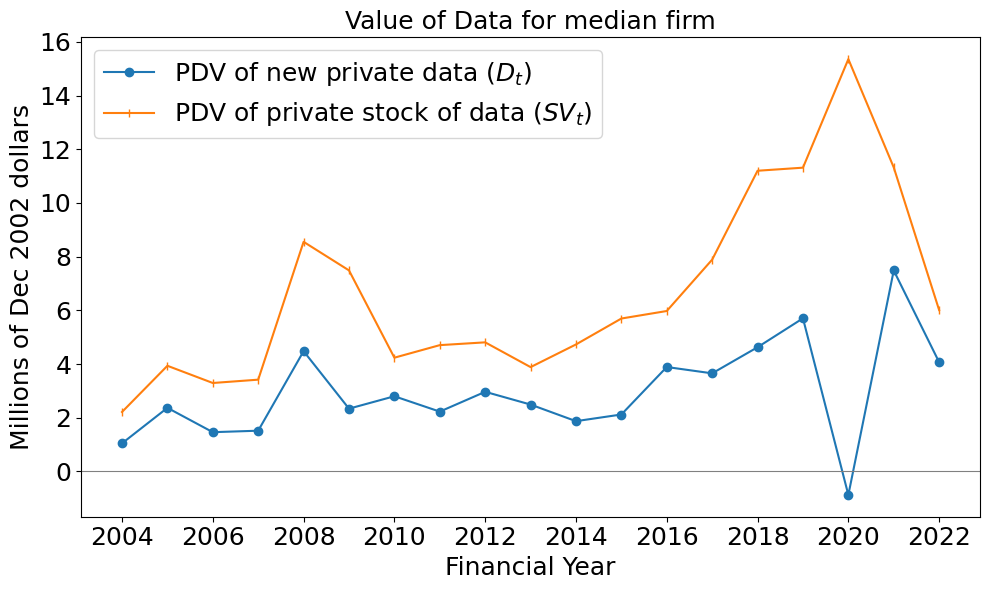

In [ ]:
method = 'mult2'
df_post_2003 = df[df['fyear']>2003]
plot_output(df_post_2003, ['FV_t', 'SV_t'],
 [r'PDV of new private data ($D_t$)', r'PDV of private stock of data ($SV_t$)'],
            'Millions of Dec 2002 dollars', 'Value of Data for median firm', f'value_of_data_{method}_model.png')

<Axes: >

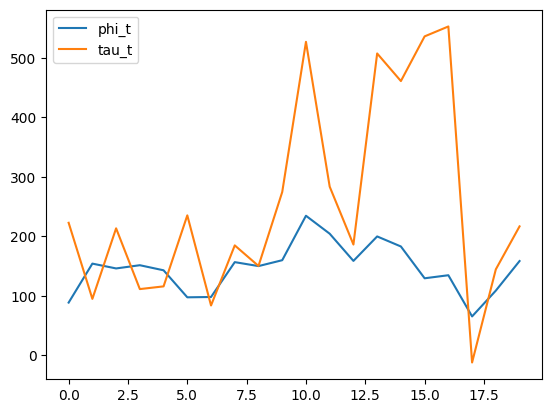

In [ ]:
df[['phi_t', 'tau_t']].plot(kind='line', legend=True)

In [ ]:
df_early = df[(df['fyear'] <= 2007) & (df['fyear'] >= 2004)]
df_late = df[(df['fyear'] <= 2017) & (df['fyear'] >= 2014)]

display(df_early[['phi_t', 'tau_t', 'FV_t', 'SV_t']].mean())
display(df_late[['phi_t', 'tau_t', 'FV_t', 'SV_t']].mean())

,0
phi_t,148.465502
tau_t,133.707580
FV_t,1.598730
SV_t,3.215580


,0
phi_t,186.339031
tau_t,359.550405
FV_t,2.884045
SV_t,6.071999


In [ ]:
revenue_array = revenue_percentiles.values
revenue_array[4]

np.float64(6817.635766862337)

In [ ]:
# Create a new dataframe by merging trimmed_ibes_comp with prior_df
merged_df = trimmed_ibes_comp.merge(prior_df, on=['gvkey', 'fyear'], how='left')
print(merged_df['sq_rel_err'].describe())
print(merged_df['sq_rel_err_prior'].describe())

# Create quintiles based on real sale for every year separately
merged_df['real_sale_quintile'] = merged_df.groupby('fyear')['real_sale'].transform(lambda x:
                                                                                    pd.qcut(x, 5, labels=False,
                                                                                            duplicates='drop'))
merged_df = merged_df[merged_df['fyear']>2002]
make_plots = False
df_list = []
for i in range(5):
    df_t = copy.deepcopy(merged_df[merged_df['real_sale_quintile'] == i])
    # Get the number of firms and total emp by firms in each year
    df_t['N_t'] = 1
    df_t = df_t.groupby('fyear').agg({'real_sale': 'median', 'sq_rel_err': 'median', 'sq_rel_err_prior': 'median', 'N_t': 'sum', 'emp': 'sum'}).reset_index()
    #df_t = df_t[['fyear', 'real_sale', 'sq_rel_err', 'sq_rel_err_prior']].groupby('fyear').median().reset_index()
    df_t['phi_t'] = 1/df_t['sq_rel_err_prior']
    df_t = val_data_calcs(df_t, V_rows[i], omega_grid, revenue_array[i])
    df_t['missing_GDP_sample'] = df_t['N_t'] * df_t['FV_t'] * 2/1000
    df_list.append(df_t)
    """
    if make_plots:
        title_str = f'Components of Data Stock over Time (Revenue Quintile Q{i+1})'
        data_stock_decomp(df_t, f'stacked_data_components_real_sale_q{i+1}.png', title_str, True)

        plot_output(df_t, ['FV_t', 'SV_t', 'val_dep'],
        [r'PDV of new private data ($FV_t$)', r'PDV of private stock of data ($SV_t$)',
          r'PDV of Depreciation $(DEP_t)$'],
                'Millions of Dec 2002 dollars', f'Value of Data (Revenue Quintile Q{i+1})', f'value_of_data_real_sale_q{i+1}.png')

        plot_output(df_t, ['FV_precision_gain', 'SV_precision_gain'], [r'Gain in precision (Flow)', r'Gain in precision (Stock)'], 'Precision',
                    f'Gain in precision (Revenue Quintile Q{i+1})', f'precision_gain_real_sale_q{i+1}.png')

        #plot_single_var(df_t, 'disc_ratio', 'Discount Ratio (FV/PQ)', '', f'Discount ratio (Revenue Quintile Q{i+1})', f'disc_ratio_q{i+1}.png')
    """

count    12525.000000
mean         0.020510
std          0.064805
min          0.000000
25%          0.000410
50%          0.002290
75%          0.010453
max          0.490651
Name: sq_rel_err, dtype: float64
count    1.251500e+04
mean     5.052594e-02
std      1.685734e-01
min      2.158635e-09
25%      1.401042e-03
50%      7.000486e-03
75%      3.013551e-02
max      3.944323e+00
Name: sq_rel_err_prior, dtype: float64
81.86931361880407
293.2660166947513


/tmp/ipython-input-4232650451.py:105: RuntimeWarning: divide by zero encountered in scalar divide
  disc_ratio = 1/(1 + rev_t/FV_t)


719.6054845966835
1809.8029429481464
6817.635766862337


In [ ]:
df_list[4]

,fyear,real_sale,sq_rel_err,sq_rel_err_prior,N_t,emp,phi_t,tau_t,Omega_t,FV_t,SV_t,FV_precision_gain,SV_precision_gain,zeta_t,undep_data,val_dep,no_dep_Omega_t,disc_ratio,missing_GDP_sample
0,2003,3683.924636,0.001468,0.007585,50,2021.054,131.835490,549.292743,681.128233,34.997796,34.997796,0.006117,0.006117,0.835383,0.000000,0.000000,681.128233,0.009411,3.499780
1,2004,5068.087657,0.001590,0.002639,114,4681.116,378.920372,159.740644,629.083885,4.335903,8.550800,0.000541,0.001049,0.610654,90.422870,-2650.786408,1087.953759,0.000855,0.988586
2,2005,5766.024230,0.001660,0.005200,129,5792.100,192.301646,312.618070,602.319874,15.725933,32.609077,0.001792,0.003540,0.752498,97.400157,-2650.786408,755.083230,0.002720,4.057291
3,2006,5536.152169,0.001518,0.003856,143,8828.061,259.363617,297.720348,658.564310,10.319801,20.698666,0.001253,0.002337,0.709923,101.480346,-2651.992379,967.102192,0.001861,2.951463
4,2007,5139.521128,0.001988,0.002961,154,6860.303,337.752031,49.375305,502.926174,1.225091,7.150259,0.000216,0.000972,0.582855,115.798838,-2646.578812,786.328029,0.000238,0.377328
5,2008,6613.462704,0.001350,0.004833,151,10665.661,206.916794,464.793579,740.611920,22.949730,35.799839,0.002275,0.003483,0.777158,68.901547,-2653.111691,836.884516,0.003458,6.930818
6,2009,6517.622051,0.002595,0.008402,111,8159.289,119.012498,147.385989,385.328211,17.201482,57.658792,0.001608,0.005807,0.758799,118.929724,-2641.316325,800.093613,0.002632,3.818729
7,2010,6424.883018,0.001033,0.003777,122,6739.931,264.749930,639.191995,968.177520,18.608904,25.809208,0.002007,0.002744,0.780950,64.235595,-2656.840373,1170.257638,0.002888,4.540573
8,2011,6642.941260,0.001673,0.003223,132,7112.327,310.248117,133.273950,597.608144,5.683237,15.640621,0.000480,0.001550,0.647196,154.086076,-2650.786408,1146.949658,0.000855,1.500375
9,2012,6013.400945,0.000654,0.005134,133,6414.047,194.774212,1232.767833,1528.923794,25.154029,39.254029,0.002723,0.004480,0.885818,101.381748,-2660.710507,1714.902072,0.004166,6.690972


In [ ]:
omega_grid

array([0.0001    , 0.00010593, 0.00011221, 0.00011887, 0.00012592,
       0.00013339, 0.0001413 , 0.00014968, 0.00015855, 0.00016795,
       0.00017792, 0.00018847, 0.00019964, 0.00021148, 0.00022403,
       0.00023731, 0.00025139, 0.0002663 , 0.00028209, 0.00029882,
       0.00031654, 0.00033531, 0.0003552 , 0.00037626, 0.00039858,
       0.00042222, 0.00044726, 0.00047378, 0.00050188, 0.00053164,
       0.00056317, 0.00059657, 0.00063195, 0.00066943, 0.00070913,
       0.00075119, 0.00079574, 0.00084293, 0.00089292, 0.00094588,
       0.00100198, 0.0010614 , 0.00112435, 0.00119103, 0.00126166,
       0.00133649, 0.00141575, 0.00149971, 0.00158865, 0.00168287,
       0.00178267, 0.00188839, 0.00200039, 0.00211902, 0.00224469,
       0.00237782, 0.00251884, 0.00266822, 0.00282646, 0.00299409,
       0.00317165, 0.00335975, 0.003559  , 0.00377007, 0.00399366,
       0.00423051, 0.0044814 , 0.00474718, 0.00502872, 0.00532695,
       0.00564287, 0.00597752, 0.00633203, 0.00670755, 0.00710

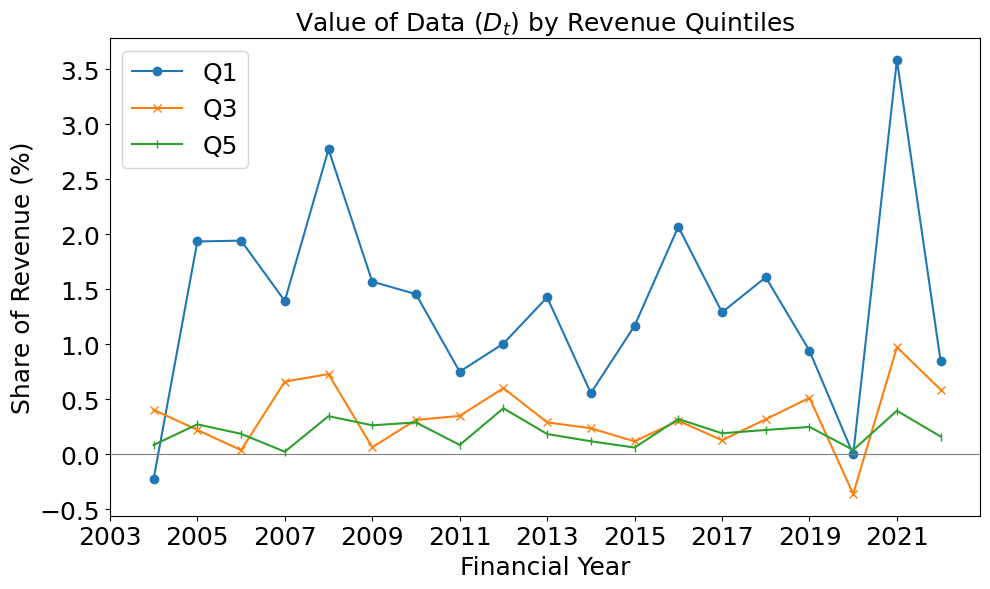

In [ ]:
# Ensure fyear is sorted and unique
years = sorted(df_t['fyear'].unique())
alternate_years = years[::2]  # Take every second year

# Set up the plot
plt.figure(figsize=(10, 6))

# Define a list of markers to cycle through
markers = ['o', '|', 'x']

# Iterate over var_list and lab_list to make the plots
for i in [0,2,4]:
    df_t = df_list[i]
    df_t = copy.deepcopy(df_t[df_t['fyear']>2003])
    df_t['data_share_rev'] = df_t['FV_t']/df_t['real_sale'] * 100
    var = 'data_share_rev'
    lab = r'Q{}'.format(i+1)
    marker = markers[i % len(markers)]
    plt.plot(df_t['fyear'], df_t[var], label=lab, marker=marker)

plt.axhline(0, color='grey', linewidth=0.8)

# Add labels and title
plt.xlabel('Financial Year', fontsize=18)
plt.ylabel('Share of Revenue (%)', fontsize=18)
plt.title(r"Value of Data $(D_t)$ by Revenue Quintiles", fontsize=18)

# Set alternate x-ticks and increase font size
plt.xticks(alternate_years, fontsize=18)
plt.yticks(fontsize=18) # Increased font size

# Add legend and grid
plt.legend(fontsize=18)
plt.tight_layout()

# Save the figure
plt.savefig(f'{project_dir}/Output/Figures/Dt_rev_alt_quintiles_{method}_model.png', dpi=300)

# Show the plot
plt.show()

In [ ]:
for i in range(0,5):
  df_t = df_list[i]
  df_t_early = df_t[(df_t['fyear'] <= 2007) & (df_t['fyear'] >= 2004)]
  df_t_late = df_t[(df_t['fyear'] <= 2017) & (df_t['fyear'] >= 2014)]
  print(f'For Q{i+1}')
  # display(df_t_early[['phi_t', 'tau_t', 'FV_t', 'SV_t']].mean())
  #display(df_t_late[['phi_t', 'tau_t', 'FV_t', 'SV_t']].mean())
  display(df_t_late[['phi_t', 'tau_t', 'FV_t', 'SV_t']].mean() / df_t_early[['phi_t', 'tau_t', 'FV_t', 'SV_t']].mean())

For Q1


,0
phi_t,1.607664
tau_t,3.251442
FV_t,1.928784
SV_t,1.724909


For Q2


,0
phi_t,1.740142
tau_t,1.852969
FV_t,1.044125
SV_t,1.137258


For Q3


,0
phi_t,1.634177
tau_t,2.302924
FV_t,1.166294
SV_t,1.170420


For Q4


,0
phi_t,1.278040
tau_t,2.318161
FV_t,1.515268
SV_t,1.713085


For Q5


,0
phi_t,1.079478
tau_t,3.696071
FV_t,1.580148
SV_t,1.521221


In [ ]:
df_t = df_list[0]
col_list = ['fyear', 'N_t', 'FV_t', 'missing_GDP_sample']
# Create a dictionary to rename all columns in col_list appending _q1
col_dict = {col: col + '_q1' for col in col_list[1:]}
sample_mgdp = copy.deepcopy(df_t[col_list].rename(columns=col_dict))

for i in range(1,5):
    df_t = df_list[i]
    col_dict = {col: col + f'_q{i+1}' for col in col_list[1:]}
    sample_mgdp = sample_mgdp.merge(df_t[col_list].rename(columns=col_dict), on='fyear', how='left')

sample_mgdp['missing_GDP_sample_total'] = (sample_mgdp['missing_GDP_sample_q1'] + sample_mgdp['missing_GDP_sample_q2'] +
                                       sample_mgdp['missing_GDP_sample_q3'] + sample_mgdp['missing_GDP_sample_q4'] + sample_mgdp['missing_GDP_sample_q5'])
sample_mgdp

,fyear,N_t_q1,FV_t_q1,missing_GDP_sample_q1,N_t_q2,FV_t_q2,missing_GDP_sample_q2,N_t_q3,FV_t_q3,missing_GDP_sample_q3,N_t_q4,FV_t_q4,missing_GDP_sample_q4,N_t_q5,FV_t_q5,missing_GDP_sample_q5,missing_GDP_sample_total
0,2003,50,2.326326,0.232633,50,5.692289,0.569229,50,2.782704,0.278270,50,7.411661,0.741166,50,34.997796,3.499780,5.321078
1,2004,115,-0.117420,-0.027007,114,0.454919,0.103722,114,1.527087,0.348176,114,4.264481,0.972302,114,4.335903,0.988586,2.385778
2,2005,129,1.102512,0.284448,128,1.764952,0.451828,128,1.120400,0.286822,128,4.039280,1.034056,129,15.725933,4.057291,6.114445
3,2006,143,1.103776,0.315680,143,1.281079,0.366389,142,0.186333,0.052919,143,3.583374,1.024845,143,10.319801,2.951463,4.711295
4,2007,155,0.696013,0.215764,154,1.429383,0.440250,154,3.119881,0.960923,154,1.133918,0.349247,154,1.225091,0.377328,2.343512
5,2008,151,1.833321,0.553663,150,2.115530,0.634659,151,4.373108,1.320679,150,6.911289,2.073387,151,22.949730,6.930818,11.513206
6,2009,111,1.237760,0.274783,111,2.097866,0.465726,111,0.431878,0.095877,111,1.582254,0.351260,111,17.201482,3.818729,5.006376
7,2010,122,1.308054,0.319165,122,1.051157,0.256482,121,2.007795,0.485886,122,4.879837,1.190680,122,18.608904,4.540573,6.792786
8,2011,132,0.686505,0.181237,132,1.415005,0.373561,132,2.308675,0.609490,132,2.146271,0.566615,132,5.683237,1.500375,3.231279
9,2012,133,0.807355,0.214756,132,1.365714,0.360548,133,3.846153,1.023077,132,2.408397,0.635817,133,25.154029,6.690972,8.925170


In [ ]:
sample_mgdp_early = sample_mgdp[(sample_mgdp['fyear'] <= 2007) & (sample_mgdp['fyear'] >= 2004)]
sample_mgdp_late = sample_mgdp[(sample_mgdp['fyear'] <= 2017) & (sample_mgdp['fyear'] >= 2014)]

['FV_t_q1', 'FV_t_q2', 'FV_t_q3', 'FV_t_q4', 'FV_t_q5']

In [ ]:
(sample_mgdp_late[[f'FV_t_q{i+1}' for i in range(5)] + [f'missing_GDP_sample_q{i+1}' for i in range(5)] + ['missing_GDP_sample_total'] + [f'N_t_q{i+1}' for i in range(5)]].mean() /
 sample_mgdp_early[[f'FV_t_q{i+1}' for i in range(5)] + [f'missing_GDP_sample_q{i+1}' for i in range(5)]  + ['missing_GDP_sample_total'] + [f'N_t_q{i+1}' for i in range(5)]].mean())

,0
FV_t_q1,1.928784
FV_t_q2,1.044125
FV_t_q3,1.166294
FV_t_q4,1.515268
FV_t_q5,1.580148
missing_GDP_sample_q1,1.759628
missing_GDP_sample_q2,0.984449
missing_GDP_sample_q3,1.096758
missing_GDP_sample_q4,1.500673
missing_GDP_sample_q5,1.536896


In [ ]:
sample_mgdp_late[[f'FV_t_q{i+1}' for i in range(5)] + [f'missing_GDP_sample_q{i+1}' for i in range(5)] + ['missing_GDP_sample_total'] + [f'N_t_q{i+1}' for i in range(5)]].mean()

,0
FV_t_q1,1.342859
FV_t_q2,1.286972
FV_t_q3,1.735942
FV_t_q4,4.932595
FV_t_q5,12.485827
missing_GDP_sample_q1,0.347036
missing_GDP_sample_q2,0.335251
missing_GDP_sample_q3,0.452095
missing_GDP_sample_q4,1.268237
missing_GDP_sample_q5,3.217749


In [ ]:
sample_mgdp_early[[f'FV_t_q{i+1}' for i in range(5)] + [f'missing_GDP_sample_q{i+1}' for i in range(5)] + ['missing_GDP_sample_total'] + [f'N_t_q{i+1}' for i in range(5)]].mean()

,0
FV_t_q1,0.696220
FV_t_q2,1.232583
FV_t_q3,1.488426
FV_t_q4,3.255263
FV_t_q5,7.901682
missing_GDP_sample_q1,0.197221
missing_GDP_sample_q2,0.340547
missing_GDP_sample_q3,0.412210
missing_GDP_sample_q4,0.845112
missing_GDP_sample_q5,2.093667


In [ ]:
sample_mgdp['missing_GDP_sample_total'].median()

16.726935202487876

In [ ]:
merged_df_copy = copy.deepcopy(merged_df)

quintile_cutoffs = (
    merged_df_copy
    .groupby('fyear')['real_sale']
    .apply(lambda x: x.quantile([0.2, 0.4, 0.6, 0.8]))
    .unstack()
    .rename(columns={0.2: 'q1', 0.4: 'q2', 0.6: 'q3', 0.8: 'q4'})
    .reset_index()
)
quintile_cutoffs

,fyear,q1,q2,q3,q4
0,2003,127.888803,287.423546,583.545462,1550.155383
1,2004,91.396939,247.831239,597.954141,1936.425108
2,2005,123.306469,339.233110,772.493621,2394.393360
3,2006,114.167357,328.353178,766.363835,2255.504788
4,2007,106.217732,308.766379,717.205707,2092.719474
5,2008,137.700613,395.930369,963.206668,2674.545646
6,2009,171.211910,437.309019,1101.826257,2944.393786
7,2010,163.191871,438.848392,1134.383337,3036.849632
8,2011,170.243107,440.537049,1167.086504,3106.677850
9,2012,172.862630,394.413253,1063.830443,2996.294468


In [ ]:
compustat_data = pd.read_csv(f'{project_dir}/Data/compustat_1980-2024.csv')

# Drop missing or negative values of sales or assets
compustat_data = compustat_data.dropna(subset=['sale', 'at'])
compustat_data = compustat_data[(compustat_data['sale'] > 0) & (compustat_data['emp'] > 0) & (compustat_data['at'] > 0) & (
    ~compustat_data['sic'].astype(str).str.startswith('67')) & (                              # To remove ETFs
        ~compustat_data['conm'].str.contains('ETF|TRUST|FUND', case=False, na=False))]        # and mutual funds

# Keep data only between 2000 - 2022
compustat_data = compustat_data[(compustat_data['fyear'] >= 2003) & (compustat_data['fyear'] <= 2022)]

# Keep only US data from major exchanges and OTC exchanges
compustat_data = compustat_data[compustat_data['fic']=='USA']
compustat_data = compustat_data[compustat_data['exchg'].isin([11, 12, 13, 14, 15, 17, 19])]

# Remove utilities and financials
#compustat_data = compustat_data[~compustat_data['sic'].between(4900, 4949)]
#compustat_data = compustat_data[~compustat_data['sic'].between(6000, 6999)]

# Keep only relevant variables
compustat_data = copy.deepcopy(compustat_data[['datadate', 'gvkey', 'fyear', 'sale', 'emp', 'at']])

compustat_data['datadate'] = pd.to_datetime(compustat_data['datadate'],format='%Y-%m-%d')

cpi_data = pd.read_csv(f'{project_dir}/Data/CPIAUCSL.csv')

# Convert datadate to datetime
compustat_data['datadate'] = pd.to_datetime(compustat_data['datadate'])  # Ensure CPI dataset is also in datetime format
cpi_data['observation_date'] = pd.to_datetime(cpi_data['observation_date'])  # Ensure CPI dataset is also in datetime format

# Extract year and month for merging
compustat_data['data_year'] = compustat_data['datadate'].dt.year
compustat_data['data_month'] = compustat_data['datadate'].dt.month
cpi_data['data_year'] = cpi_data['observation_date'].dt.year
cpi_data['data_month'] = cpi_data['observation_date'].dt.month


# Merge CPI data into merged_final
compustat_data = compustat_data.merge(cpi_data, on=['data_year', 'data_month'], how='left')

# Get CPI for December 2002
cpi_dec_2002 = cpi_data.loc[cpi_data['observation_date'] == '2002-12-01', 'CPIAUCSL'].values[0]

compustat_data['real_sale'] = compustat_data['sale'] / compustat_data['CPIAUCSL'] * cpi_dec_2002
compustat_data

,datadate,gvkey,fyear,sale,emp,at,data_year,data_month,observation_date,CPIAUCSL,real_sale
0,2004-05-31,1004,2003.0,651.958,2.300,709.292,2004,5,2004-05-01,188.200,629.787271
1,2005-05-31,1004,2004.0,747.848,2.600,732.230,2005,5,2005-05-01,193.600,702.266355
2,2006-05-31,1004,2005.0,897.284,3.300,978.819,2006,5,2006-05-01,201.300,810.363791
3,2007-05-31,1004,2006.0,1061.169,3.900,1067.633,2007,5,2007-05-01,206.755,933.087588
4,2008-05-31,1004,2007.0,1384.919,5.400,1362.010,2008,5,2008-05-01,215.208,1169.929901
...,...,...,...,...,...,...,...,...,...,...,...
91297,2021-12-31,345980,2021.0,2085.000,1.218,1283.000,2021,12,2021-12-01,280.808,1349.865388
91298,2022-12-31,345980,2022.0,571.000,0.886,799.000,2022,12,2022-12-01,298.812,347.401711
91299,2021-12-31,347007,2021.0,0.934,0.587,468.910,2021,12,2021-12-01,280.808,0.604688
91300,2022-12-31,347007,2022.0,0.240,0.725,362.356,2022,12,2022-12-01,298.812,0.146018


In [ ]:
# Merge the cutoffs into the other dataset
compustat_data = compustat_data.merge(quintile_cutoffs, on='fyear', how='left')

# Define a function to assign quintiles using the cutoffs
def assign_quintile(row):
    if pd.isna(row['q1']):
        return np.nan
    elif row['real_sale'] <= row['q1']:
        return 0
    elif row['real_sale'] <= row['q2']:
        return 1
    elif row['real_sale'] <= row['q3']:
        return 2
    elif row['real_sale'] <= row['q4']:
        return 3
    else:
        return 4

# Apply the function
compustat_data['real_sale_quintile'] = compustat_data.apply(assign_quintile, axis=1)
compustat_data.groupby(['fyear', 'real_sale_quintile'])['real_sale'].min()

fyear   real_sale_quintile
2003.0  0                        0.000980
        1                      127.920101
        2                      287.691885
        3                      584.220106
        4                     1550.347278
                                 ...     
2022.0  0                        0.000608
        1                      226.187717
        2                      586.475537
        3                     1303.591761
        4                     3327.147103
Name: real_sale, Length: 100, dtype: float64

In [ ]:
# Group by fyear and real_sale_quintile and count the occurrences
firm_counts = compustat_data.groupby(['fyear', 'real_sale_quintile']).size().reset_index(name='count')

# Pivot the table to have fyear as rows, real_sale_quintile as columns, and count as values
firms_per_quintile_year = firm_counts.pivot(index='fyear', columns='real_sale_quintile', values='count').reset_index()
firms_per_quintile_year.columns = ['fyear'] + [f'pub_N_t_q{i}' for i in range(1,6)]
firms_per_quintile_year['fyear'] = firms_per_quintile_year['fyear'].astype(int)
firms_per_quintile_year

,fyear,pub_N_t_q1,pub_N_t_q2,pub_N_t_q3,pub_N_t_q4,pub_N_t_q5
0,2003,3297,685,606,652,779
1,2004,2797,829,732,750,706
2,2005,2864,827,633,679,628
3,2006,2605,825,643,653,691
4,2007,2431,811,593,657,723
5,2008,2304,763,616,540,618
6,2009,2474,679,593,474,519
7,2010,2290,684,594,488,533
8,2011,2218,625,580,495,541
9,2012,2184,510,624,511,577


In [ ]:
# Merge with df_mgdp to assess the missing GDP in public firms
pub_mgdp = sample_mgdp[['fyear'] + [f'FV_t_q{i}' for i in range(1,6)]].merge(firms_per_quintile_year, on='fyear', how='left')
pub_mgdp['missing_GDP_total_pub'] = 0.0
for i in range(1,6):
    pub_mgdp[f'missing_GDP_pub_q{i}'] = pub_mgdp[f'pub_N_t_q{i}'] * pub_mgdp[f'FV_t_q{i}'] * 2 / 1000
    pub_mgdp['missing_GDP_total_pub'] += pub_mgdp[f'missing_GDP_pub_q{i}']
pub_mgdp

,fyear,FV_t_q1,FV_t_q2,FV_t_q3,FV_t_q4,FV_t_q5,pub_N_t_q1,pub_N_t_q2,pub_N_t_q3,pub_N_t_q4,pub_N_t_q5,missing_GDP_total_pub,missing_GDP_pub_q1,missing_GDP_pub_q2,missing_GDP_pub_q3,missing_GDP_pub_q4,missing_GDP_pub_q5
0,2003,2.326326,5.692289,2.782704,7.411661,34.997796,3297,685,606,652,779,90.702241,15.339796,7.798436,3.372637,9.664806,54.526567
1,2004,-0.117420,0.454919,1.527087,4.264481,4.335903,2797,829,732,750,706,14.852078,-0.656850,0.754256,2.235656,6.396722,6.122294
2,2005,1.102512,1.764952,1.120400,4.039280,15.725933,2864,827,633,679,628,35.889963,6.315191,2.919231,1.418427,5.485343,19.751772
3,2006,1.103776,1.281079,0.186333,3.583374,10.319801,2605,825,643,653,691,27.045931,5.750674,2.113780,0.239625,4.679887,14.261965
4,2007,0.696013,1.429383,3.119881,1.133918,1.225091,2431,811,593,657,723,12.664105,3.384017,2.318460,3.700179,1.489968,1.771482
5,2008,1.833321,2.115530,4.373108,6.911289,22.949730,2304,763,616,540,618,52.893968,8.447942,3.228299,5.387669,7.464192,28.365866
6,2009,1.237760,2.097866,0.431878,1.582254,17.201482,2474,679,593,474,519,28.840663,6.124437,2.848903,0.512208,1.499977,17.855139
7,2010,1.308054,1.051157,2.007795,4.879837,18.608904,2290,684,594,488,533,34.413941,5.990886,1.437983,2.385260,4.762721,19.837091
8,2011,0.686505,1.415005,2.308675,2.146271,5.683237,2218,625,580,495,541,15.766226,3.045335,1.768756,2.678063,2.124808,6.149263
9,2012,0.807355,1.365714,3.846153,2.408397,25.154029,2184,510,624,511,577,41.208683,3.526526,1.393028,4.799999,2.461381,29.027749


In [ ]:
pub_mgdp_early = pub_mgdp[(pub_mgdp['fyear'] <= 2007) & (pub_mgdp['fyear'] >= 2004)]
pub_mgdp_late = pub_mgdp[(pub_mgdp['fyear'] <= 2017) & (pub_mgdp['fyear'] >= 2014)]

(pub_mgdp_late[[f'FV_t_q{i+1}' for i in range(5)] + [f'missing_GDP_pub_q{i+1}' for i in range(5)]  + ['missing_GDP_total_pub'] +  [f'pub_N_t_q{i+1}' for i in range(5)]].mean() /
 pub_mgdp_early[[f'FV_t_q{i+1}' for i in range(5)] + [f'missing_GDP_pub_q{i+1}' for i in range(5)]  + ['missing_GDP_total_pub'] + [f'pub_N_t_q{i+1}' for i in range(5)]].mean())

,0
FV_t_q1,1.928784
FV_t_q2,1.044125
FV_t_q3,1.166294
FV_t_q4,1.515268
FV_t_q5,1.580148
missing_GDP_pub_q1,1.446048
missing_GDP_pub_q2,0.752303
missing_GDP_pub_q3,0.991209
missing_GDP_pub_q4,0.949886
missing_GDP_pub_q5,1.193140


In [ ]:
pub_mgdp_late[[f'FV_t_q{i+1}' for i in range(5)] + [f'missing_GDP_pub_q{i+1}' for i in range(5)]  + ['missing_GDP_total_pub'] +  [f'pub_N_t_q{i+1}' for i in range(5)]].mean()

,0
FV_t_q1,1.342859
FV_t_q2,1.286972
FV_t_q3,1.735942
FV_t_q4,4.932595
FV_t_q5,12.485827
missing_GDP_pub_q1,5.347859
missing_GDP_pub_q2,1.524491
missing_GDP_pub_q3,1.881782
missing_GDP_pub_q4,4.286818
missing_GDP_pub_q5,12.500377


In [ ]:
pub_mgdp_early[[f'FV_t_q{i+1}' for i in range(5)] + [f'missing_GDP_pub_q{i+1}' for i in range(5)]  + ['missing_GDP_total_pub'] +  [f'pub_N_t_q{i+1}' for i in range(5)]].mean()

,0
FV_t_q1,0.696220
FV_t_q2,1.232583
FV_t_q3,1.488426
FV_t_q4,3.255263
FV_t_q5,7.901682
missing_GDP_pub_q1,3.698258
missing_GDP_pub_q2,2.026432
missing_GDP_pub_q3,1.898472
missing_GDP_pub_q4,4.512980
missing_GDP_pub_q5,10.476878


In [ ]:
## Option 1 - extrapolating the number from public firms
# Get the number of people employed by public firms
emp_pub = compustat_data.groupby('fyear')['emp'].sum().reset_index().rename(columns={'emp':'emp_pub'})

# Get total employment in the economy
df_emp = pd.read_csv(f'{project_dir}/Data/employment_CE16OV.csv')
df_emp = pd.merge(df_emp, emp_pub, on='fyear', how='left')
df_emp = df_emp.merge(pub_mgdp[['fyear', 'missing_GDP_total_pub']], on='fyear', how='left')
df_emp['missing_GDP_econ'] = df_emp['missing_GDP_total_pub']/ df_emp['emp_pub'] * df_emp['total_emp']
# Deciding to go with extrapolating from
df_emp

,fyear,total_emp,emp_pub,missing_GDP_total_pub,missing_GDP_econ
0,2003,137729,35643.8210,90.702241,350.476707
1,2004,139240,36202.0635,14.852078,57.123908
2,2005,141710,37052.2020,35.889963,137.264895
3,2006,144418,37774.1100,27.045931,103.402019
4,2007,146050,37742.5195,12.664105,49.005541
5,2008,145373,36821.6479,52.893968,208.827015
6,2009,139894,35212.0405,28.840663,114.581137
7,2010,139077,36029.5584,34.413941,132.840587
8,2011,139885,36912.5091,15.766226,59.748267
9,2012,142475,37689.4689,41.208683,155.778453


In [ ]:
df_emp_early = df_emp[(df_emp['fyear'] <= 2007) & (df_emp['fyear'] >= 2004)]
df_emp_late = df_emp[(df_emp['fyear'] <= 2017) & (df_emp['fyear'] >= 2014)]

In [ ]:
df_emp_late.mean()/df_emp_early.mean()

,0
fyear,1.004986
total_emp,1.049906
emp_pub,1.072226
missing_GDP_total_pub,1.129497
missing_GDP_econ,1.113967


In [ ]:
rgdp = pd.read_csv(f'{project_dir}/Data/GDPC1.csv')
rgdp['observation_date'] = pd.to_datetime(rgdp['observation_date'])  # Ensure CPI dataset is also in datetime format
rgdp['fyear'] = rgdp['observation_date'].dt.year
rgdp = rgdp.merge(sample_mgdp[['fyear', 'missing_GDP_sample_total']], on='fyear', how='inner')
rgdp = rgdp.merge(pub_mgdp[['fyear', 'missing_GDP_total_pub']], on='fyear', how='inner')
rgdp = rgdp.merge(df_emp[['fyear', 'missing_GDP_econ']], on='fyear', how='inner')

# Get CPI numbers
cpi_data = pd.read_csv(f'{project_dir}/Data/CPIAUCSL.csv')
cpi_data['observation_date'] = pd.to_datetime(cpi_data['observation_date'])  # Ensure CPI dataset is also in datetime format
cpi_dec_2002 = cpi_data.loc[cpi_data['observation_date'] == '2002-12-01', 'CPIAUCSL'].values[0]
cpi_jun_2017 = cpi_data.loc[cpi_data['observation_date'] == '2017-06-01', 'CPIAUCSL'].values[0]

for col in ['missing_GDP_sample_total', 'missing_GDP_total_pub', 'missing_GDP_econ']:
    rgdp[col + '_Jun2017'] = rgdp[col] * cpi_jun_2017 / cpi_dec_2002
    rgdp[col + '_share'] = rgdp[col + '_Jun2017']/rgdp['GDPC1'] * 100

rgdp

,observation_date,GDPC1,fyear,missing_GDP_sample_total,missing_GDP_total_pub,missing_GDP_econ,missing_GDP_sample_total_Jun2017,missing_GDP_sample_total_share,missing_GDP_total_pub_Jun2017,missing_GDP_total_pub_share,missing_GDP_econ_Jun2017,missing_GDP_econ_share
0,2003-01-01,14877.313,2003,14.403005,239.732034,926.333161,19.343679,0.130021,321.967507,2.164151,1244.093969,8.362357
1,2004-01-01,15449.757,2004,6.278202,39.886949,153.412768,8.431818,0.054576,53.569401,0.346733,206.038073,1.333601
2,2005-01-01,15987.958,2005,17.463719,99.495314,380.530176,23.454312,0.146700,133.625271,0.835787,511.063748,3.196554
3,2006-01-01,16433.148,2006,13.463305,74.420727,284.525367,18.081633,0.110031,99.949328,0.608218,382.126332,2.325339
4,2007-01-01,16762.446,2007,6.494015,34.261790,132.580827,8.721662,0.052031,46.014639,0.274510,178.060134,1.062256
5,2008-01-01,16781.485,2008,32.440618,145.350538,573.848399,43.568750,0.259624,195.210249,1.163248,770.696077,4.592538
6,2009-01-01,16349.111,2009,13.237985,73.446467,291.795645,17.779022,0.108746,98.640868,0.603341,391.890539,2.397014
7,2010-01-01,16789.751,2010,19.527135,94.872004,366.213583,26.225544,0.156200,127.416024,0.758892,491.836123,2.929383
8,2011-01-01,17052.411,2011,8.144590,39.200883,148.557105,10.938435,0.064146,52.647993,0.308742,199.516768,1.170021
9,2012-01-01,17442.759,2012,24.809842,113.184306,427.863126,33.320382,0.191027,152.010009,0.871479,574.633358,3.294395


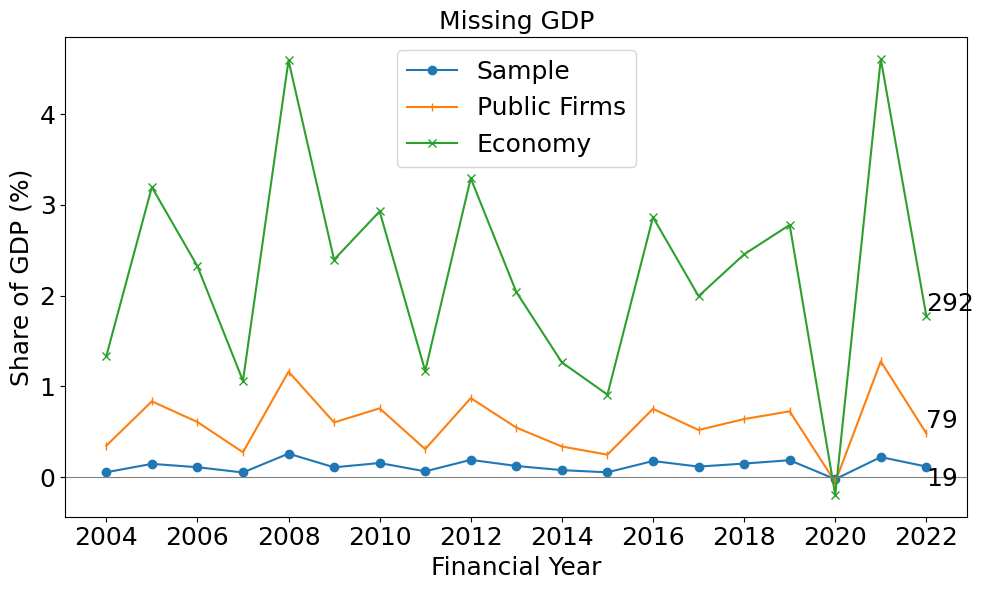

In [ ]:
def plot_output_with_text(df, var_list, lab_list, text_list, ylab, title, filename):
    # Ensure fyear is sorted and unique
    years = sorted(df['fyear'].unique())
    alternate_years = years[::2]  # Take every second year

    # Define a list of markers to cycle through
    markers = ['o', '|', 'x']

    # Set up the plot
    plt.figure(figsize=(10, 6))

    # Iterate over var_list, lab_list, and markers to make the plots
    for i, (var, lab) in enumerate(zip(var_list, lab_list)):
        # Use the modulo operator to cycle through markers
        marker = markers[i % len(markers)]
        plt.plot(df['fyear'], df[var], label=lab, marker=marker)

        # Add text for the last observation
        last_year = df['fyear'].iloc[-1]
        last_value = df[var].iloc[-1]
        if i>0:
            plt.text(last_year, last_value, text_list[i], fontsize=18, ha='left', va='bottom') # Added text annotation
        else:
            plt.text(last_year, last_value, text_list[i], fontsize=18, ha='left', va='top') # Added text annotation


    plt.axhline(0, color='grey', linewidth=0.8)

    # Add labels and title
    plt.xlabel('Financial Year', fontsize=18) # Increased font size
    plt.ylabel(ylab, fontsize=18) # Increased font size
    plt.title(title, fontsize=18) # Increased font size

    # Set alternate x-ticks and increase font size
    plt.xticks(alternate_years, fontsize=18)
    plt.yticks(fontsize=18) # Increased font size

    # Add legend and grid, and increase legend font size
    plt.legend(fontsize=18)
    plt.tight_layout()

    # Save the figure
    plt.savefig(f'{project_dir}/Output/Figures/{filename}', dpi=300)

    # Show the plot
    plt.show()

t1 = rgdp.loc[rgdp['fyear']==2022, 'missing_GDP_sample_total'].values[0]
t2 = rgdp.loc[rgdp['fyear']==2022, 'missing_GDP_total_pub'].values[0]
t3 = rgdp.loc[rgdp['fyear']==2022, 'missing_GDP_econ'].values[0]

rgdp_post_2003 = rgdp[rgdp['fyear']>2003]

plot_output_with_text(rgdp_post_2003, ['missing_GDP_sample_total_share', 'missing_GDP_total_pub_share', 'missing_GDP_econ_share'],
            ['Sample', 'Public Firms', 'Economy'], [f'{t1:.0f}', f'{t2:.0f}', f'{t3:.0f}'],
                      'Share of GDP (%)', 'Missing GDP', f'missing_GDP_share_{method}_model.png')

In [ ]:
rgdp_post_2003['missing_GDP_econ_share'].mean()

np.float64(2.2526662483531052)

In [ ]:
1/0.007

142.85714285714286

In [ ]:
1/0.002

500.0

In [ ]:
zeta = 1 - 1/(0.95**2 + 0.007/0.002)
zeta

0.7728563316297559

In [ ]:
zeta * (1/0.002 - 1/0.007)

276.0201184391985

In [ ]:
def nearest_idx(grid, values):
    return np.abs(grid[None, :] - values[:, None]).argmin(axis=1)

# Get nearest indices for prior and posterior
idx_prior = nearest_idx(omega_grid, df['sq_rel_err_prior'].values)
idx_post  = nearest_idx(omega_grid, df['sq_rel_err'].values)

# Compute value differences
df['V_diff'] = V_med[idx_post] - V_med[idx_prior]

# Inspect results
print(df[['sq_rel_err_prior', 'sq_rel_err', 'V_diff']].head())

   sq_rel_err_prior  sq_rel_err    V_diff
0          0.010968    0.003215  2.641939
1          0.006488    0.003345  1.348857
2          0.007047    0.002439  1.904913
3          0.006541    0.002999  1.482512
4          0.007093    0.003155  1.588056


In [ ]:
df

,fyear,real_sale,sq_rel_err,sq_rel_err_prior,phi_t,V_diff
0,2003,413.006478,0.003215,0.010968,91.174940,2.641939
1,2004,376.497653,0.003345,0.006488,154.138479,1.348857
2,2005,504.782705,0.002439,0.007047,141.907679,1.904913
3,2006,489.210843,0.002999,0.006541,152.870712,1.482512
4,2007,471.128924,0.003155,0.007093,140.990424,1.588056
5,2008,599.778838,0.002577,0.010082,99.187171,2.887556
6,2009,672.768822,0.004153,0.010400,96.154678,2.224750
7,2010,641.558478,0.002607,0.006395,156.369501,1.548881
8,2011,661.159354,0.002722,0.006663,150.087429,1.603067
9,2012,639.487108,0.002004,0.006273,159.420424,1.778186


In [ ]:
omega_grid[51]

np.float64(0.0018883946770417803)

In [ ]:
der_wrt_var = (V_med[52] - V_med[51])/(omega_grid[52] - omega_grid[51])
print(der_wrt_var)

-1322.9082200142516


In [ ]:
der_real_2024 = der_wrt_var/181.8 * 317.7
der_real_2024

np.float64(-2311.814859727875)

In [ ]:
omega_grid[51]

np.float64(0.0018883946770417803)

In [ ]:
V_med[14] - V_med[51]

np.float64(0.11401141978967644)

In [ ]:
prec_with_bought_data = 1/(PHI + TAU) - 1.67/(-der_real_2024)
prec_with_bought_data

np.float64(0.0014759091519162266)

In [ ]:
PSI = 1/prec_with_bought_data - PHI - TAU
print(PSI)

222.64847830685477


In [ ]:
import math
math.sqrt(0.009)

0.09486832980505137

In [ ]:
0.095/0.002

47.5

In [ ]:
1.67/722.36

0.0023118666592834595

In [ ]:
omega_grid

array([0.00125954, 0.0013036 , 0.00134921, 0.00139641, 0.00144526,
       0.00149582, 0.00154815, 0.00160231, 0.00165837, 0.00171639,
       0.00177643, 0.00183858, 0.0019029 , 0.00196947, 0.00203837,
       0.00210968, 0.00218349, 0.00225988, 0.00233894, 0.00242076,
       0.00250545, 0.0025931 , 0.00268382, 0.00277771, 0.00287489,
       0.00297546, 0.00307956, 0.0031873 , 0.0032988 , 0.00341421,
       0.00353365, 0.00365727, 0.00378522, 0.00391764, 0.0040547 ,
       0.00419655, 0.00434336, 0.00449531, 0.00465258, 0.00481534,
       0.00498381, 0.00515816, 0.00533861, 0.00552538, 0.00571868,
       0.00591875, 0.00612581, 0.00634012, 0.00656192, 0.00679149,
       0.00702908, 0.00727499, 0.0075295 , 0.00779291, 0.00806554,
       0.00834771, 0.00863975, 0.008942  , 0.00925483, 0.00957861])

In [ ]:
print(omega_grid[50])
print(omega_grid[14])

0.00702908124927092
0.002038372553472878


In [ ]:
print(V_med[50])
print(V_med[14])

14484.267795825263
14486.330775205872


In [ ]:
CHI

119